In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.inference import DBNInference

c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generer des données 

Nous allons cnstruire un HMM très simple. 

Dans ce HMM, le vercteur d'état sera de dimension 1 et le vecteur de variables observé de dimension 1 également. Nous noterons 
- $S_t$ l'état à l'instant t
- $Y_t$ la variable observé à l'instant t 

Dans notre exemple très simple, on suppose que l'état vérifie: 
$$ S_t \in {-1, 0, 1}, Y_t \in {-1, 0, 1} $$ 

On suppose que la table qui donne les changements d'états entre deux instants est le suivant:

\begin{array}{|c|c|c|c|}
    \hline
    S_t \rightarrow S_{t+1} & \text{-1} & \text{0} & \text{1} \\
    \hline
    \text{-1} & \text{0.5} & \text{0.5} & \text{0} \\
    \text{0} & \text{0.2} & \text{0.2} & \text{0.6} \\
    \text{1} & \text{0.} & \text{0.9} & \text{1} \\
    \hline
\end{array}

et, que la dépendance de la variable d'observation à l'état s'écrit comme suit:

\begin{array}{|c|c|c|c|}
    \hline
    S_t \rightarrow Y_t & \text{-1} & \text{0} & \text{1} \\
    \hline
    \text{-1} & \text{0.8} & \text{0.1} & \text{0.1} \\
    \text{0} & \text{0.} & \text{1.} & \text{0.} \\
    \text{1} & \text{0.1} & \text{0.1} & \text{0.8} \\
    \hline
\end{array}


In [2]:
# function to generate data 

def generate_data(nb):
    """
    Given an integer generate data as describe above.

    :params nb: int 
        Number of datapoints to generate

    :return dictionary 
        Keys are "States" and "Observations". 
    """
    
    # initialize state vector 
    S = np.zeros(nb, dtype=np.int16)
    ps = {  # table as above
        -1: [.5, .5, 0.], 
        0: [.2, .2, .6], 
        1: [0., .9, .1]
    }
    
    # initialize observation vector
    Y = np.zeros(nb, dtype=np.int16)
    py = {  # table as above
        -1: [.8, .1, .1], 
        0: [0., 1, 0.], 
        1: [.1, .1, .8]
    }

    for i in range(nb): 
        if i == 0:
            S[i] = np.random.randint(-1, 2)
        else: 
            S[i] = np.random.choice([-1, 0, 1], p=ps.get(S[i-1]))
        Y[i] = np.random.choice([-1, 0, 1], p=py.get(S[i]))

    return {"States": S, "Observations": Y}

### Création du modèle

doc: https://pgmpy.org/models/dbn.html

La class DynamicBayesian network nécessite cependant que les données lui soient données sous un certain format. Nous préparons donc les données pour notr modèle.

In [3]:
# nb data points to generate
nb_data_points = 10  # means 10 time steps


# generate 1000 paths of 10 time steps
data = [generate_data(nb_data_points) for _ in range(1000)]

# define states and observations 
states = [d.get("States") for d in data]
obs = [d.get("Observations") for d in data]

# construct dataframe as required by DBN class
matrix = np.zeros((1000, nb_data_points*2))
for i in range(1000):
    for j in range(nb_data_points):
        matrix[i, 2*j] = states[i][j]
        matrix[i, 2*j+1] = obs[i][j]

# name columns as required by DBN class
columns = []
for j in range(nb_data_points):
    columns.extend([("States", j), ("Obs", j)])

df_me = pd.DataFrame(matrix, columns=columns)

df_me.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   (States, 0)  1000 non-null   float64
 1   (Obs, 0)     1000 non-null   float64
 2   (States, 1)  1000 non-null   float64
 3   (Obs, 1)     1000 non-null   float64
 4   (States, 2)  1000 non-null   float64
 5   (Obs, 2)     1000 non-null   float64
 6   (States, 3)  1000 non-null   float64
 7   (Obs, 3)     1000 non-null   float64
 8   (States, 4)  1000 non-null   float64
 9   (Obs, 4)     1000 non-null   float64
 10  (States, 5)  1000 non-null   float64
 11  (Obs, 5)     1000 non-null   float64
 12  (States, 6)  1000 non-null   float64
 13  (Obs, 6)     1000 non-null   float64
 14  (States, 7)  1000 non-null   float64
 15  (Obs, 7)     1000 non-null   float64
 16  (States, 8)  1000 non-null   float64
 17  (Obs, 8)     1000 non-null   float64
 18  (States, 9)  1000 non-null   float64
 19  (Obs, 9

A noter ci-dessus que pour entrapiner le DBN, les données doivent être données sous la forme d'un pandas dataframe et de la forme (nom du noeud, time slice)

Désormais, nous pouvons construire un modèle et l'entraîner:

In [6]:
# build model 
dbn = DBN(
    [
        (("States", 0), ("Obs", 0)),
        (("States", 0), ("States", 1)),
        (('States', 1), ("Obs", 1))
    ]
)

second_option = """ 
    model.add_nodes_from(['State', 'Obs'])
    model.add_edge(('State', 0), ('State', 1))
    model.add_edge(('State', 0), ('Obs', 0))
    model.add_edge(('State', 1), ('Obs', 1))
"""

print("\nNote that you can also build the same model using this code:\n", second_option)


Note that you can also build the same model using this code:
  
    model.add_nodes_from(['State', 'Obs'])
    model.add_edge(('State', 0), ('State', 1))
    model.add_edge(('State', 0), ('Obs', 0))
    model.add_edge(('State', 1), ('Obs', 1))



In [7]:
# train the model 
dbn.fit(df_me)

Maintenant que le modèle est entraîné, nous pouvons vérifier s'il a bien retrouvé la loi avec laquelle nous avons construit nos données: 

In [8]:
for cpd in dbn.get_cpds():
    print(cpd)

+----------------+----------+
| (States, 0)(0) | 0.231222 |
+----------------+----------+
| (States, 0)(1) | 0.464333 |
+----------------+----------+
| (States, 0)(2) | 0.304444 |
+----------------+----------+
+-------------+---------------------+----------------+---------------------+
| (States, 0) | (States, 0)(0)      | (States, 0)(1) | (States, 0)(2)      |
+-------------+---------------------+----------------+---------------------+
| (Obs, 0)(0) | 0.7808469055814456  | 0.0            | 0.09948241205027579 |
+-------------+---------------------+----------------+---------------------+
| (Obs, 0)(1) | 0.1062428840589589  | 1.0            | 0.09658920553625065 |
+-------------+---------------------+----------------+---------------------+
| (Obs, 0)(2) | 0.11291021035959543 | 0.0            | 0.8039283824134735  |
+-------------+---------------------+----------------+---------------------+
+----------------+-----+---------------------+
| (States, 0)    | ... | (States, 0)(2)      |
+--

Dans le deuxième tableau, on retrouve bien la table qui nous a permis le changement d'étant d'un instant t à un instant t+1. De même, dans le dernier tableau on retrouve la table qui lie l'état à l'observation à chaque instant t. 

Notons tout de même, que cela n'a rien d'impressionnant (consiste essentiellement en des calculs de moyennes) mais nous permet simplement de vérifier le bon fonctionnement de notre code et donc d'un début de compréhension. 

Nous pouvons souligner ici les limites de l'estimation des paramètres par maximum de vraisemblance. En effet, dans un cas avec très peu de données et sans prior imposé, nous avons de grandes chances d'overfit les données d'entraînement. 

Toutefois, le modèle présente de nombreux avantages. Nous pouvons voir les bénéfices d'un tel modèle dans son utilisation en inférence:

### Inference

Une question que l'on pourrait se poser lorsque nous utilisons un HMM est: étant donné une observation à l'instant t=0, quel sera l'état à l'instant t+1 ? 

In [46]:
# this cell is just to show an example 
# framework pour l'inférence des DBN 
inference = DBNInference(dbn)

# known observation
evidence = {('Obs', 0): 1}  # value must be indice 

message = """ 
    /!\ evidence = {('Obs', 0): 1} does not mean that observation at time 0 
    is 1 but that observation at time 0 is 0. In fact, reading error messages, 
    it seems that the value in the dictionary is used as index not as value. 
    \n Code for testing yourself: set evidence = {('Obs', 0): 27} raise 
    IndexError: index 27 is out of bounds for axis 0 with size .
    \n You can also notice that if you set value to -1 or 2 (i.e nb of states)
    you get the same results.
"""
print(message)

# result of question given evidence what about variable
result = inference.query(variables=[('States', 1)], evidence=evidence)
print("Get probability for each state", result[("States", 1)].values)

 
    /!\ evidence = {('Obs', 0): 1} does not mean that observation at time 0 
    is 1 but that observation at time 0 is 0. In fact, reading error messages, 
    it seems that the value in the dictionary is used as index not as value. 
    
 Code for testing yourself: set evidence = {('Obs', 0): 27} raise 
    IndexError: index 27 is out of bounds for axis 0 with size .
    
 You can also notice that if you set value to -1 or 2 (i.e nb of states)
    you get the same results.

Get probability for each state [0.21106712 0.25036956 0.53856332]


Etudions le cas où nous observons une valeur de -1 à l'instant 0. Quel serait la valeur de l'état à l'instant 1 ? 

Text(0, 0.5, 'Proba')

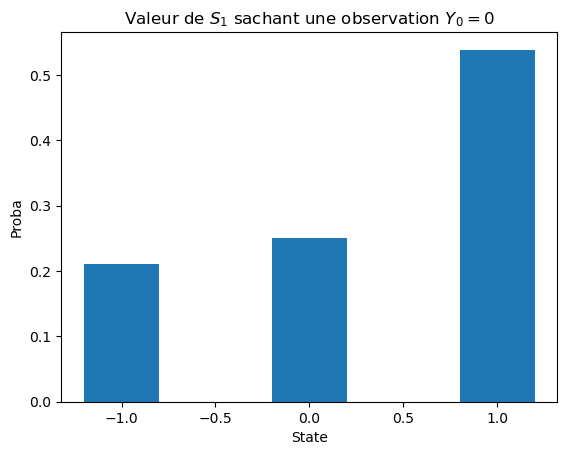

In [43]:
# framework pour l'inférence des DBN 
inference = DBNInference(dbn)

# known observation
evidence = {('Obs', 0): 1}  # value must be indice 

# result of question given evidence what about variable
result = inference.query(variables=[('States', 1)], evidence=evidence)
proba = result[("States", 1)].values

plt.title("Valeur de $S_1$ sachant une observation $Y_0=0$")
plt.bar(np.arange(-1, 2), proba, width=0.4)
plt.xlabel("State")
plt.ylabel("Proba")

Ce résultat est cohérent. Je n'ai pas refait le calcul mais en observant $Y_0 = 0$, il y a de grandes chances qu'on soit dans l'état $S_0=0$ (selon la table de passage de S à Y). Puis, cette fois en regardant la table de passage de l'instant t à t+1, $S_1$ à de bonnes chances de valoir 1 si $S_0=0$.

c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:799: RuntimeWarning: divide by zero encountered in divide
  phi.values = phi.values / phi1.values
c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:799: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi1.values


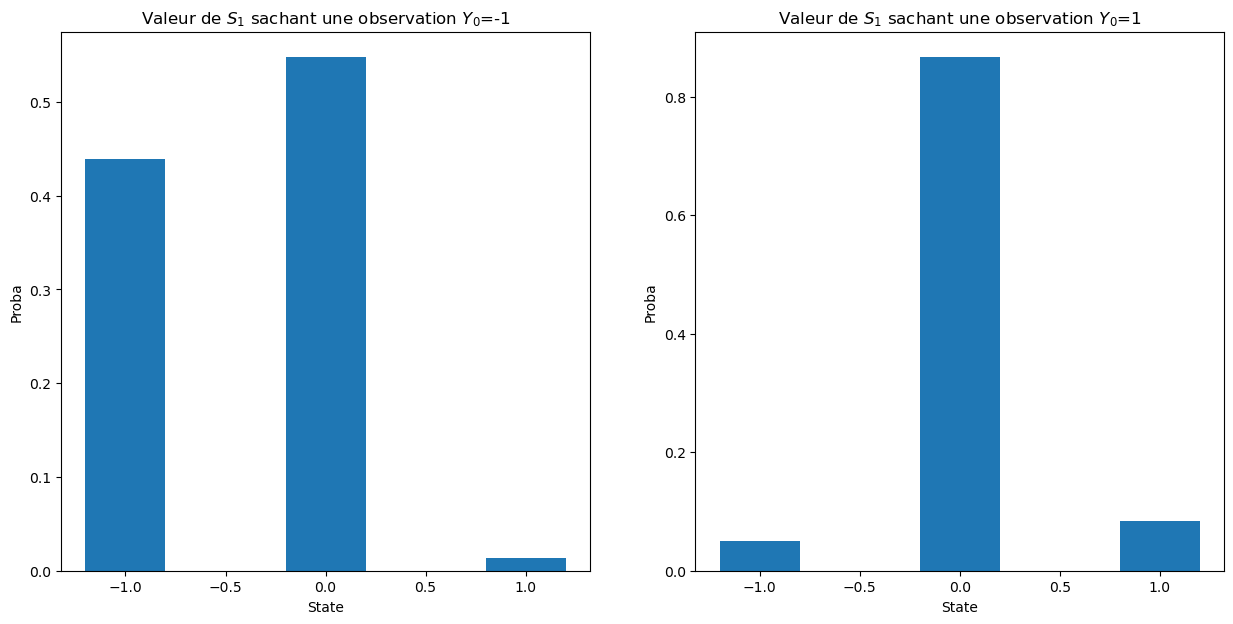

In [44]:
# framework pour l'inférence des DBN 
inference = DBNInference(dbn)

# known observation
evidences = [{('Obs', 0): 0}, {('Obs', 0): 2}]  

# result of question given evidence what about variable
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

for i, evidence in enumerate(evidences): 
    result = inference.query(variables=[('States', 1)], evidence=evidence)
    proba = result[("States", 1)].values

    y0 = evidence.get(('Obs', 0))
    ax[i].set_title(f"Valeur de $S_1$ sachant une observation $Y_0$={y0-1}")
    ax[i].bar(np.arange(-1, 2), proba, width=0.4)
    ax[i].set_xlabel("State")
    ax[i].set_ylabel("Proba")

Encore une fois, à l'intuition on peut expliquer ces résultats. Pour être sûr à 100%, nous pourrons éventuellement refaire les calculs manuellement. 

### Conclusion

Ainsi, un intérêt du DBN malgré l'exemple simplissime est sa capacité à évaluer un risque. En effet, supposons que l'état $S = -1$ représente un risque qu'il nous faudrait anticiper. En observant par exemple aujourd'hui $Y_0 = 0$ on pourrait mesurer le risque que demain on soit dans l'état $S_1 = -1$ égal dans notre cas à 21%.

Il reste maintenant à voir dans quelles contextes réels les réseaux bayésiens à noeuds discrets peuvent être utiles.  